In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Save the train and test DataFrames
X_TRAIN_DIR = "processed_data/glcm/X_train.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4129, 61)
(4129,)
(1030, 61)
(1030,)


In [12]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def tensorflow_neural_network_classification(X_train, y_train, X_test, y_test):
    """
    Perform neural network multiclass classification using TensorFlow, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training labels.
    X_test (pd.DataFrame): Testing features.
    y_test (pd.Series): Testing labels.

    Returns:
    None
    """
    # Create a label encoder
    label_encoder = LabelEncoder()

    # Encode the class labels
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    class_labels = label_encoder.classes_

    # Define a Sequential model
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.2),  
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(len(class_labels), activation='softmax')  # Use softmax in the output layer
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train_encoded, epochs=200, verbose=0)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

    # Predict labels
    y_pred_prob = model.predict(X_test)
    y_pred = [class_labels[idx] for idx in np.argmax(y_pred_prob, axis=1)]

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


33/33 [==============================] - 0s 767us/step


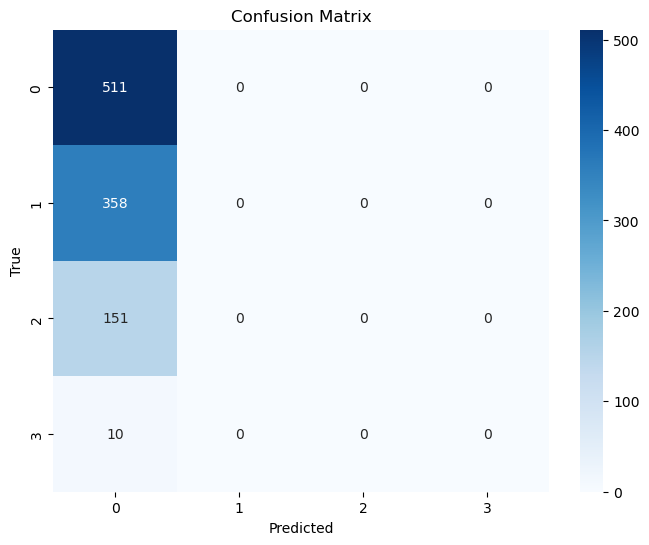

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       511
           1       0.00      0.00      0.00       358
           2       0.00      0.00      0.00       151
           3       0.00      0.00      0.00        10

    accuracy                           0.50      1030
   macro avg       0.12      0.25      0.17      1030
weighted avg       0.25      0.50      0.33      1030



c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
tensorflow_neural_network_classification(X_train, y_train, X_test, y_test)


In [15]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt

def build_model(hp, class_labels):
    model = keras.Sequential()
    model.add(keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(len(class_labels), activation='softmax'))

    # Tune the number of units in the first dense layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.layers[0].units = hp_units

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
class_labels = label_encoder.classes_

tuner = kt.RandomSearch(
    lambda hp: build_model(hp, class_labels),
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='my_project'
)

tuner.search(X_train, y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = build_model(best_hps, class_labels)


Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.4961165189743042

Best val_accuracy So Far: 0.5718446373939514
Total elapsed time: 00h 01m 53s


33/33 [==============================] - 0s 660us/step


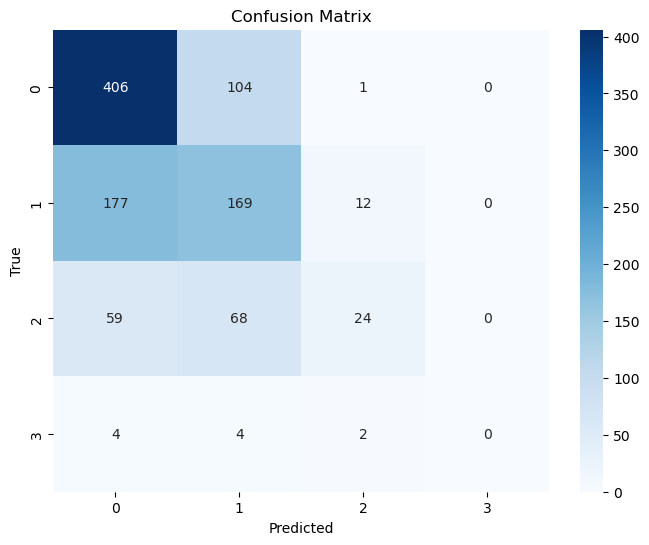

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       511
           1       0.49      0.47      0.48       358
           2       0.62      0.16      0.25       151
           3       0.00      0.00      0.00        10

    accuracy                           0.58      1030
   macro avg       0.43      0.36      0.36      1030
weighted avg       0.57      0.58      0.55      1030



c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
best_model.fit(X_train, y_train_encoded, epochs=200, verbose=0)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_encoded, verbose=0)

# Predict labels
y_pred_prob = best_model.predict(X_test)
y_pred = [class_labels[idx] for idx in np.argmax(y_pred_prob, axis=1)]

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))